# Catatan Cakrawala Notebook
Seluruh kode dan additional files dapat diakses pada responsitory kami [disini](https://github.com/Hyuto/NLP/blob/master/RPU.py)

Model : EfficientnetB5
<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" alt="Efficentnet" width="600" height="600" style="display: block; margin-left: auto; margin-right: auto;"/>

Efficientnet adalah preTrained model yang cukup populer belakangan ini karena performanya pada imagenet cukup mengesankan. Pada Kernel ini akan digunakan EfficientNetB5 dengan `noisy-student` sebagai weight nya.

# Download Efficient Net & Funsi Tambahan
Download EfficientNet inference untuk Tensorflow keras & fungsi tambahan untuk preprocessing

In [1]:
!pip install -q --upgrade pip
!pip install -q efficientnet
!wget https://raw.githubusercontent.com/Hyuto/NLP/master/RPU.py

--2020-09-12 04:26:09--  https://raw.githubusercontent.com/Hyuto/NLP/master/RPU.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8605 (8.4K) [text/plain]
Saving to: ‘RPU.py’

RPU.py              100%[===================>]   8.40K  --.-KB/s    in 0s      

2020-09-12 04:26:10 (56.3 MB/s) - ‘RPU.py’ saved [8605/8605]



# Import Libraries
Import Libraries yang diperlukan

In [2]:
# Basic
import os, random
import numpy as np
import pandas as pd
from PIL import Image
from timeit import default_timer
from tqdm.notebook import tqdm

# Kaggle Datasets for checking GCS
from kaggle_datasets import KaggleDatasets

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow and Keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint

# EfficientNet
import efficientnet.tfkeras as efn

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.transform import rotate

print(f'Tensorflow Version {tf.__version__}')

Tensorflow Version 2.2.0


## SEED ALL
SEED ALL untuk hasil yang stabil.

In [3]:
# SEED ALL
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = str(SEED)
tf.random.set_seed(SEED)

## GCS PATH
Google Cloud Storage PATH untuk dataset 

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH

'gs://kds-e72faf09b7abe6659cf2a74651fa963dfd447ee1a1d190bbabc55803'

# Load Dataset
Load dataset ke memory

In [5]:
train = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/Data Latih BDC.xlsx')
test = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/Data Uji BDC.xlsx')
train

ID  label              tanggal  \
0         71      1  2020-08-17 00:00:00   
1        461      1  2020-07-17 00:00:00   
2        495      1  2020-07-13 00:00:00   
3        550      1  2020-07-08 00:00:00   
4        681      1  2020-06-24 00:00:00   
...      ...    ...                  ...   
4226  999287      1  2016-01-17 00:00:00   
4227  999472      1  2020-08-20 00:00:00   
4228  999501      1  2020-08-17 00:00:00   
4229  999848      1  2020-07-21 00:00:00   
4230  999860      1  2020-07-20 00:00:00   

                                                  judul  \
0     Pemakaian Masker Menyebabkan Penyakit Legionna...   
1     Instruksi Gubernur Jateng tentang penilangan  ...   
2     Foto Jim Rohn: Jokowi adalah presiden terbaik ...   
3     ini bukan politik, tapi kenyataan Pak Jokowi b...   
4          Foto Kadrun kalo lihat foto ini panas dingin   
...                                                 ...   
4226  : KPK Dilarang Membawa Brimob Bersenjata Masuk...   
4227            Foto pejabat keuangan dibawah palu arit   
4228  Gambar Denny Siregar Musuh Warga Tasikmalaya d...   
4229  Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...   
4230  Laser dari termometer gun akan merusak struktu...   

                                                 narasi nama file gambar  
0     A caller to a radio talk show recently shared ...           71.jpg  
1     Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...          461.png  
2     Jokowi adalah presiden terbaik dlm sejarah ban...          495.png  
3     Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...          550.png  
4           Kadrun kalo lihat foto ini panas dingin . .          681.jpg  
...                                                 ...              ...  
4226  KPK Dilarang Membawa Brimob Bersenjata Masuk G...       999287.jpg  
4227  Jangan mau dialihkan kepada pakaian adat… FOKU...       999472.png  
4228                 Akhir nya bisa terkenal bang denny       999501.jpg  
4229  Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...       999848.jpg  
4230  IN: Saya nolak. Kalau Anda mau periksa, bukan ...       999860.png  

[4231 rows x 6 columns]

Cek perbedaan kelas dengan melihat proposinya

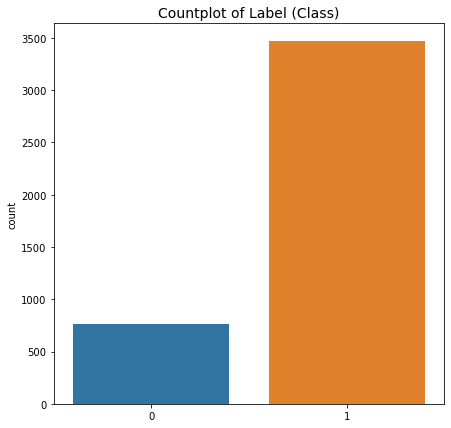

In [6]:
plt.figure(figsize = (7, 7))
sns.countplot(train.label.values)
plt.title('Countplot of Label (Class)', fontsize = 14)
plt.show()

### Insight:
Terdapat `class imbalance` pada data sehingga perlu penanganan khusus saat melakukan pengolahan. Pada notebook ini masalah ini akan diatasi dengan menggunakan upsampling data menggunakan `image augmentation` serta dalam pembagian data utuk pelatihan dilakukan `stratify` agar proporsi setiap kelasnya dalam data valid dan data train sama

# Preprocess Data
Memproses data sebelum diolah

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   tanggal           4231 non-null   object
 3   judul             4231 non-null   object
 4   narasi            4231 non-null   object
 5   nama file gambar  4231 non-null   object
dtypes: int64(2), object(4)
memory usage: 198.5+ KB


Sesuaikan PATH untuk file gambar

In [8]:
# Train & Test Image PATH
TRAIN_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/'
TEST_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/'

In [9]:
TRAIN_IMG = [TRAIN_PATH + x for x in train['nama file gambar'].values]
TEST_IMG = [TEST_PATH + x for x in test['nama file gambar'].values]

## Checking Missing Data
Mengecek apakah ada data yang hilang / tidak bisa terbaca pada direktori yang sudah di tetapkan.

In [10]:
def check_missing(files, return_missing_ID = True):
    """
    Mengecek keberadaan data gambar berdasarkan direktori
    """
    missing = []
    for file in files:
        if not os.path.isfile(file):
            missing.append(file)
    print(f'[INFO] Missing {len(missing)} file')
    if return_missing_ID:
        return sorted([int(x.split('/')[-1][:-4]) for x in missing])

In [11]:
# Missing pada data TRAIN
missing_train = check_missing(TRAIN_IMG)
missing_train

[INFO] Missing 9 file


[48121, 275477, 343052, 367583, 555990, 697754, 697955, 742855, 743885]

Ada beberapa gambar yang hilang / tidak terbaca pada direktori data latih(train). Sekarang kita coba cek untuk data testing.

In [12]:
# Missing pada data TEST
missing_test = check_missing(TEST_IMG)
missing_test

[INFO] Missing 2 file


[690192, 693499]

Pada data test juga terdapat beberapa file gambar yang hilang.

Sepertinya ada beberapa file yang hilang itu karena penamaan file di csvnya beda dengan nama file yang ada di derektori gambarnya.

In [13]:
def fixing_extensions(missing, path):
    """
    Membenarkan ekstensi file gambar yang di anggap hilang
    dari direktori.
    """
    res = []
    for miss in missing:
        fixed = False
        list_dir = os.listdir(path)
        for i in range(len(list_dir)):
            if miss == int(list_dir[i][:-4]):
                fixed = True
                res.append((miss, list_dir[i]))
                break
        if not fixed:
            res.append((miss, None))
    return res

In [14]:
fixed_missing_train = fixing_extensions(missing_train, TRAIN_PATH)
fixed_missing_test = fixing_extensions(missing_test, TEST_PATH)

Applying missing data yang telah di benarkan ekstensinya

In [15]:
for Id, filename in fixed_missing_train:
    index = train.ID.tolist().index(Id)
    train.loc[index, 'nama file gambar'] = filename
# Drop data yang ada NAN-nya
train = train.dropna()

for Id, filename in fixed_missing_test:
    index = test.ID.tolist().index(Id)
    test.loc[index, 'nama file gambar'] = filename
# Drop data yang ada NAN-nya
test = test.dropna()

Spesifikasi data X dan Y

In [16]:
TRAIN_X, TRAIN_y = [TRAIN_PATH + x for x in train['nama file gambar'].values], train.label.values

Menampilkan data gambar pada Train dataset

In [17]:
def read_and_resize(path):
    """
    Read & Resize data gambar
    """
    img = Image.open(path)
    img.resize((256, 256), Image.ANTIALIAS)
    return img

def show_images(list_dir, label, load_image = read_and_resize, seed = SEED):
    """
    Menampilkan Gambar Secara acak berdasarkan kelasnya 
    masing - masing sebanyak 5 buah.
    """
    random.seed(seed)
    data_0 = random.sample([x for x in zip(list_dir, label) if x[1] == 0], 5)
    data_1 = random.sample([x for x in zip(list_dir, label) if x[1] == 1], 5)
    fig, axes = plt.subplots(2, 5, figsize = (20, 10))
    for i in range(2):
        if i == 0:
            data = data_0
        else:
            data = data_1
        for j in range(5):
            img = load_image(data[j][0])
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Label : {data[j][1]}', fontsize = 14)
            axes[i, j].axis('off')
    fig.tight_layout()
    plt.show()

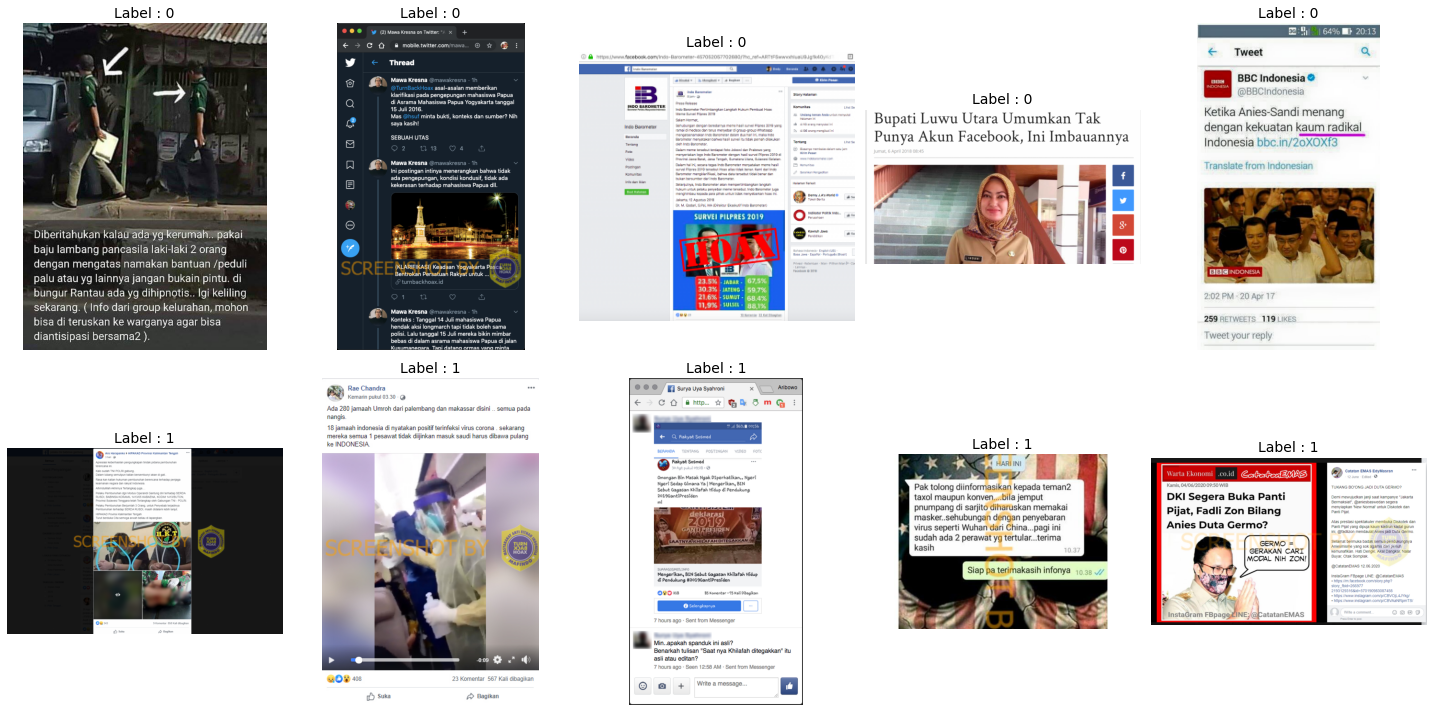

In [18]:
show_images(TRAIN_X, TRAIN_y)

Karna ukuran gambarnya yang berbeda - beda akan dilakukan pemfokusan kedaerah tengah dari setiap data gambar, selanjutnya dilakukan resize data gambar ke ukuran yang diinginkan. 

In [19]:
def load_and_preprocess_image(path: str, size = [256, 256]):
    """
    Load & Preprocess data gambar
    """
    image = img_to_array(load_img(path))
    img = tf.convert_to_tensor(image, dtype=tf.float32)
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    dim = tf.minimum(h, w)
    img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

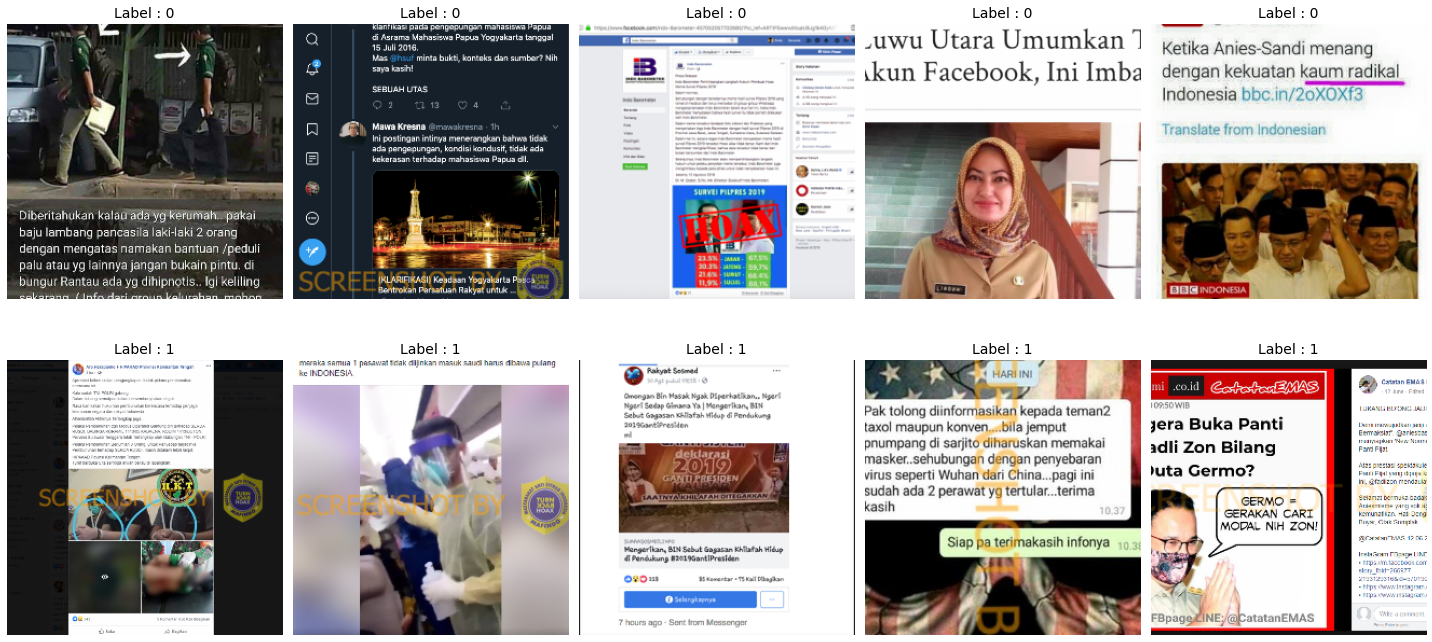

In [20]:
show_images(TRAIN_X, TRAIN_y, load_and_preprocess_image)

## Image Augmentation
Karena data train yang ada belum cukup banyak, data tersebut bisa di lipat gandakan dengan melakukan augmentasi.

Augmentasi yang digunakan pada kernal ini yaitu.
```
Rotasi Acak dengan nilai rotasi di random pada kisaran -70 sd 70 derajad
```

In [21]:
data_augmentation = lambda x : (
    rotate(x, random.randint(-70, 70), mode='reflect')
)

In [22]:
def AUG_test(X):
    """
    Plot gambar dengan fungsi Augmentasi
    """
    X = load_and_preprocess_image(X)
    fig, axes = plt.subplots(1, 5, figsize = (20,10))
    axes[0].imshow(X)
    axes[0].set_title('Actual', fontsize = 14)
    axes[0].axis('off')
    for i in range(1, 5):
        aug = data_augmentation(X)
        axes[i].imshow(aug)
        axes[i].set_title('Augmented', fontsize = 14)
        axes[i].axis('off')
    fig.tight_layout()
    return plt.show()

Cek Augmentasi

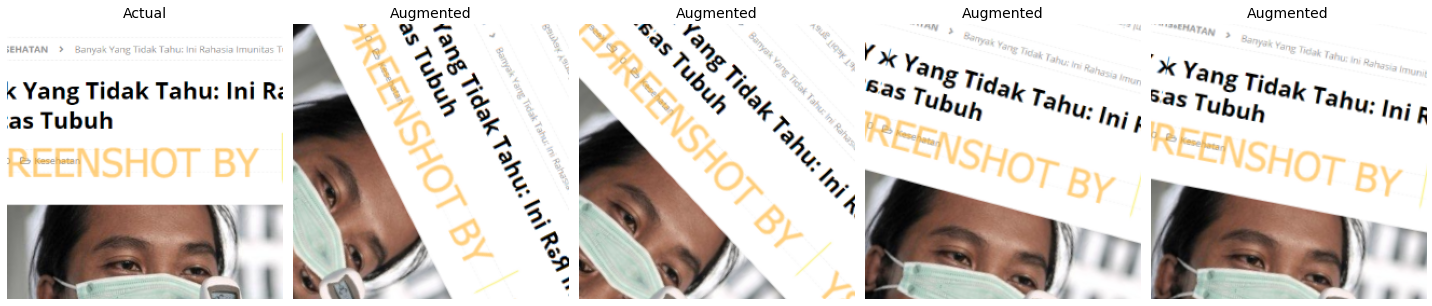

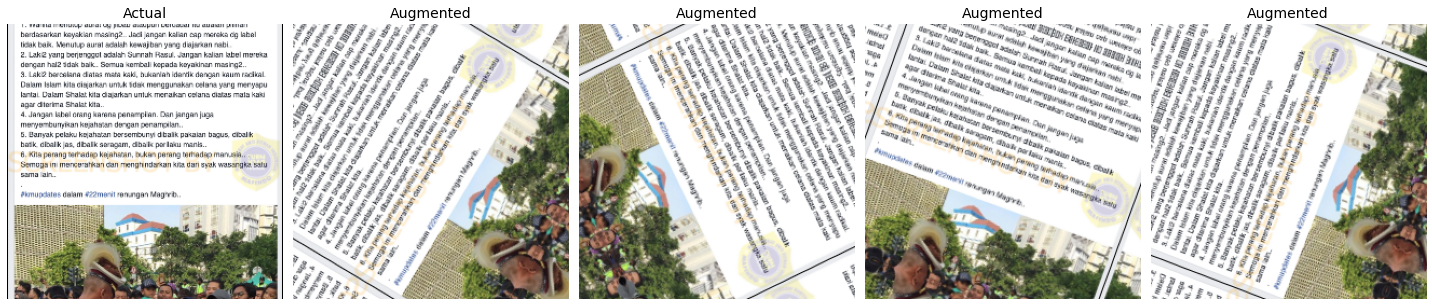

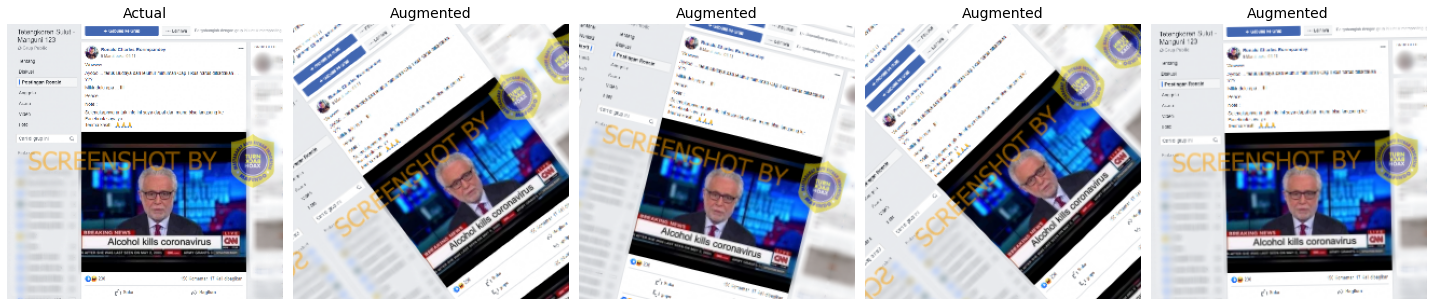

In [23]:
for i in random.sample(TRAIN_X, 3):
    AUG_test(i)

# Apply Preprocessing & Up Sampling
Mengapply Preprocess & Augmentasi ke data gambar dan menyimpan gambar pada direktori baru.
Menggunakan Fungsi tambahan yang sudah di download pada file `RPU.py`

Fungsi akan mengembalikan List direktori gambar dan juga labelnya.

`ApplyAUG -> IMAGE_DIR, Label`

Contoh Penggunaan
```
from RPU import ApplyAUG

TRAIN_X, TRAIN_y = (
       ApplyAUG(TRAIN_X,               # List atau Array direktori dari gambar
                TRAIN_y,               # List atau Array kelas(label) dari TRAIN_X [One Hot Encoding]
                PATH,                  # Direktori data gambar
                up_sample_ratio = 1,   # Rasio Up Sample
                up_sample_class = '0', # Spesifikasi Class yang akan di Up Sample  
                data_aug = data_augmentation,  # Fungsi Augmentasi
                LP = load_and_preprocess_image # Fungsi Load & Preprocess
                )
)
```
Atau bisa juga menggunakan shell
```
!python RPU.py PATH SIZE TEST_SIZE UP_SAMPLES UP_SAMPLE_CLASS
```
Namun pada kernel ini tidak akan di gunakan fungsi tersebut. Melaikan menggunakan hasil dari fungsi tersebut, karena kernel ini di run pada TPU & TPU tidak dapat membaca diluar dari `GCS` (lokal direktori).

Note : Up Sample data pada kernel ini didapatkan dengan command berikut
```
!python RPU.py '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/' \
                SIZE:512 TEST_SIZE:0.15 UP_SAMPLES:0.5-1-2 UP_SAMPLE_CLASS:0
```

# Load Up Sample Data
Load data dari Upsampling data directory.
```
Preprocessed  Upsampling
    |--- Up-Sample-0-by-50%
    |--- Up-Sample-0-by-100%
    |--- Up-Sample-0-by-200%
    |--- Validitas
```
Pada Kernel ini akan di gunakan 3 tipe upsampling data untuk melihat apakah dengan melakukan Up sampling data dengan menggunakan augmentasi memberikan perbedaan yang signifikan terhadap akurasi.

In [24]:
# Train Data
train_prep_0 = pd.read_csv('../input/data-bdc/Preprocess and Up Sample/Up-Sample-0-by-50%/Keterangan.csv')
train_prep_1 = pd.read_csv('../input/data-bdc/Preprocess and Up Sample/Up-Sample-0-by-100%/Keterangan.csv')
train_prep_2 = pd.read_csv('../input/data-bdc/Preprocess and Up Sample/Up-Sample-0-by-200%/Keterangan.csv')
# Valid Data
valid_prep = pd.read_csv('../input/data-bdc/Validitas/Keterangan.csv')

In [25]:
# Spesifikasi PATH data train pada GCS
AUG_PATH = GCS_PATH + '/Preprocess and Up Sample/'
# Data Up Sample 50% 
TRAIN_X_0 = [AUG_PATH + x for x in train_prep_0.DIR.values]
TRAIN_y_0 = train_prep_0.label.values
# Data Up Sample 100% 
TRAIN_X_1 = [AUG_PATH + x for x in train_prep_1.DIR.values]
TRAIN_y_1 = train_prep_1.label.values
# Data Up Sample 200% 
TRAIN_X_2 = [AUG_PATH + x for x in train_prep_2.DIR.values]
TRAIN_y_2 = train_prep_2.label.values

# Spesifikasi PATH data Valid pada GCS
VAL_X = [GCS_PATH + '/' + x for x in valid_prep.DIR.values]
VAL_y = valid_prep.label.values

# Spesifikasi PATH data test pada GCS
TEST_PATH = GCS_PATH + '/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/'
TEST_X = [TEST_PATH + x for x in test['nama file gambar'].values]

# Shuffle Data
TRAIN_X_0, TRAIN_y_0 = shuffle(TRAIN_X_0, TRAIN_y_0, 
                               random_state = SEED)
TRAIN_X_1, TRAIN_y_1 = shuffle(TRAIN_X_1, TRAIN_y_1, 
                               random_state = SEED)
TRAIN_X_2, TRAIN_y_2 = shuffle(TRAIN_X_2, TRAIN_y_2, 
                               random_state = SEED)

## Accelerator Detection
Menggunakan GPU atau TPU dari Kaggle sebagai Accelerator.

Note : Pastikan untuk menyalakan GPU / TPU sebagai Accelator, untuk effisiensi waktu pelatihan model.

In [26]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
else:
    print('Running on GPU')
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    
AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Tensorflow Data
Untuk efisiensi memmory digunakan `tensorflow.data.Dataset`

In [27]:
def decode_image(filename, label=None, image_size=(512, 512)):
    """
    Decode Image from String Path Tensor
    """
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    if label is None:
        shapes = tf.shape(image)
        h, w = shapes[-3], shapes[-2]
        dim = tf.minimum(h, w)
        image = tf.image.resize_with_crop_or_pad(image, dim, dim)
        image = tf.image.resize(image, image_size)
        return image
    else:
        image = tf.image.resize(image, image_size)
        return image, label

In [28]:
# TF Train Dataset
train_dataset = {
'50%' : (tf.data.Dataset
         .from_tensor_slices((TRAIN_X_0, TRAIN_y_0))
         .map(decode_image, num_parallel_calls=AUTO)
         .cache()
         .repeat()
         .shuffle(1024)
         .batch(BATCH_SIZE)
         .prefetch(AUTO)),
    
'100%' : (tf.data.Dataset
          .from_tensor_slices((TRAIN_X_1, TRAIN_y_1))
          .map(decode_image, num_parallel_calls=AUTO)
          .cache()
          .repeat()
          .shuffle(1024)
          .batch(BATCH_SIZE)
          .prefetch(AUTO)),

'200%' : (tf.data.Dataset
          .from_tensor_slices((TRAIN_X_2, TRAIN_y_2))
          .map(decode_image, num_parallel_calls=AUTO)
          .cache()
          .repeat()
          .shuffle(1024)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))
}

# TF Valid Dataset
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((VAL_X, VAL_y))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# TF Test Dataset
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(TEST_X)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

# Modelling
Scope model ke TPU.

Model : `EfficientNetB7 noisy-student` 

In [29]:
def Make_EfficientNet_model():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(            # EfficientnetB5
            input_shape=(512, 512, 3),
            weights='noisy-student',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(1, activation='sigmoid')
    ])
    return model

## Metrics
Memasukan metrics F1 score

In [30]:
# Taken from old keras source code
def F1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

# Fitting Model
Dilakukan fitting model sebanyak 10 kali epochs untuk tiap - tiap datasetnya dan dilakukan penyimpanan weights untuk model terbaik dengan memonitori nilai `Accuracy` pada validitation data lalu untuk setiap model terbaik pada setiap datasetnya dilakukan pendugaan terhadap test dataset.

In [31]:
EPOCHS = 10
LENGTH = {'50%' : len(TRAIN_X_0), '100%' : len(TRAIN_X_1), '200%' : len(TRAIN_X_2)}
HISTORY = {}
PREDS = {}

print('[INFO] Starting Process')
start = default_timer()
for data in train_dataset:
    # Cleaning everything
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # Select Train dataset
    print(f'[INFO] Processed to Fit Model at {data}-up-sampling-train-dataset')
    dataset = train_dataset[data]
    
    # Fitting Config
    STEPS_PER_EPOCH = LENGTH[data] // BATCH_SIZE
    VAL_STEPS = len(VAL_X) // BATCH_SIZE
    checkpoint = ModelCheckpoint(f'{data}_best_model.h5', monitor='val_accuracy', 
                                 save_best_only=True, save_weights_only=True, 
                                 mode='max')
    
    # Build & Compile Model
    print(f'[INFO] Build & Compiling Model')
    with strategy.scope():
        model = Make_EfficientNet_model()
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy', F1]
    )
    
    # Fitting Model
    print(f'[INFO] Fitting Model')
    history = model.fit(
        dataset, 
        epochs = EPOCHS, verbose = 0,
        steps_per_epoch = STEPS_PER_EPOCH,
        validation_data = valid_dataset,
        callbacks = [checkpoint]
    )
    HISTORY[data] = history.history
    
    # Load Best Weight
    model.load_weights(f'{data}_best_model.h5')
    
    # Making Predictions for Test Dataset
    print(f'[INFO] Predicting for Test Dataset')
    pred = model.predict_classes(test_dataset, verbose = 0)
    PREDS[data] = [x[0] for x in pred]
    print('[INFO] Done')
print(f'[INFO] Complete Process in {round(default_timer() - start, 2)}s')

[INFO] Starting Process
[INFO] Processed to Fit Model at 50%-up-sampling-train-dataset
[INFO] Build & Compiling Model
258072576/258068648 [==============================] - 9s 0us/step
[INFO] Fitting Model
[INFO] Predicting for Test Dataset
[INFO] Done
[INFO] Processed to Fit Model at 100%-up-sampling-train-dataset
[INFO] Build & Compiling Model
[INFO] Fitting Model
[INFO] Predicting for Test Dataset
[INFO] Done
[INFO] Processed to Fit Model at 200%-up-sampling-train-dataset
[INFO] Build & Compiling Model
[INFO] Fitting Model
[INFO] Predicting for Test Dataset
[INFO] Done
[INFO] Complete Process in 2472.74s


Melihat train progress untuk data Validation.

In [32]:
fitting_progress = pd.DataFrame({'Epochs' : range(1, EPOCHS + 1)})
for data in HISTORY:
    histories = HISTORY[data]
    for history in histories:
        if 'val' in history:
            fitting_progress[data + ' ' + history] = histories[history]

cm = sns.light_palette("#2ecc71", as_cmap=True)
fitting_progress = fitting_progress.style.background_gradient(cmap=cm)
fitting_progress

In [33]:
fitting_progress.to_excel('Progress.xlsx', index = False)

### Insight:
Terdapat kenaikan `loss` pada setiap epochnya, Up Sample Data 200% memberikan model dengan hasil terbaik yaitu dengan nilai `val_accuracy` terbesar. Diduga adanya overfit pada model karena nilai `loss` nya yang cenderung naik namun nilai `accuracy` dan `F1 score` yang cukup stabil.

Visualize Training loss & F1 score

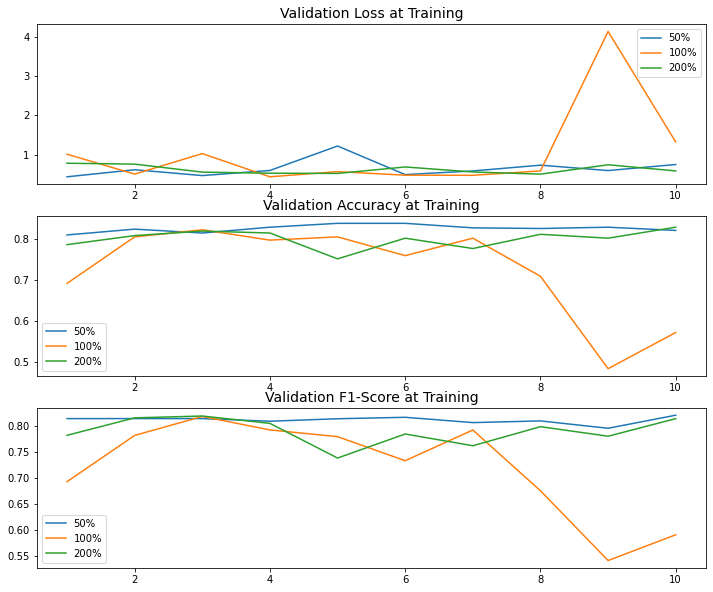

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 10))
ax1.plot(range(1, EPOCHS + 1), HISTORY['50%']['val_loss'], label = '50%')
ax1.plot(range(1, EPOCHS + 1), HISTORY['100%']['val_loss'], label = '100%')
ax1.plot(range(1, EPOCHS + 1), HISTORY['200%']['val_loss'], label = '200%')
ax1.set_title('Validation Loss at Training', fontsize = 14)
ax1.legend()
ax2.plot(range(1, EPOCHS + 1), HISTORY['50%']['val_accuracy'], label = '50%')
ax2.plot(range(1, EPOCHS + 1), HISTORY['100%']['val_accuracy'], label = '100%')
ax2.plot(range(1, EPOCHS + 1), HISTORY['200%']['val_accuracy'], label = '200%')
ax2.set_title('Validation Accuracy at Training', fontsize = 14)
ax2.legend()
ax3.plot(range(1, EPOCHS + 1), HISTORY['50%']['val_F1'], label = '50%')
ax3.plot(range(1, EPOCHS + 1), HISTORY['100%']['val_F1'], label = '100%')
ax3.plot(range(1, EPOCHS + 1), HISTORY['200%']['val_F1'], label = '200%')
ax3.set_title('Validation F1-Score at Training', fontsize = 14)
ax3.legend()
plt.show()

### Insight:
Dari Lineplot di atas dapat diketahui jika:
1. Loss cenderung menaik, sedangkan nilai Accuracy dan F1 cukup stabil. Hal ini menandakan mungkin terjadi Overfit pada training data.
1. Dengan dilakukannya Up Sampling dengan Image Augmentation tidak memberikan pengaruh yang signifikan terhadap nilai loss, akurasi, maupun nilai F1 scorenya.

# Predict Data Test
Memilih prediksi terhadap data test yang sudah dilakukan sebelumnya. Karena dari segi nilai `val_accuracy`-nya model pada Up Sample data 200% memberikan hasil yang lebih baik dari yang lainnya, maka pada kernel ini akan digunakan prediksi dari model yang dilatih pada data Up Sample 200%.

In [35]:
best_predictions = PREDS['200%']

## Frekuensi per Kelas Hasil Prediksi
Melihat Frekuensi per kelas dari hasil prediksi.

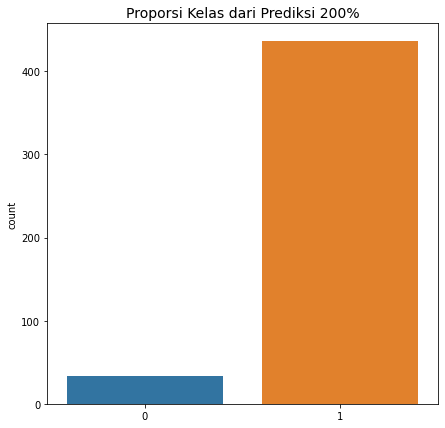

In [36]:
plt.figure(figsize = (7, 7))
sns.countplot(best_predictions)
plt.title(f'Proporsi Kelas dari Prediksi 200%', fontsize = 14)
plt.show()

Cek data gambar hasil prediksi

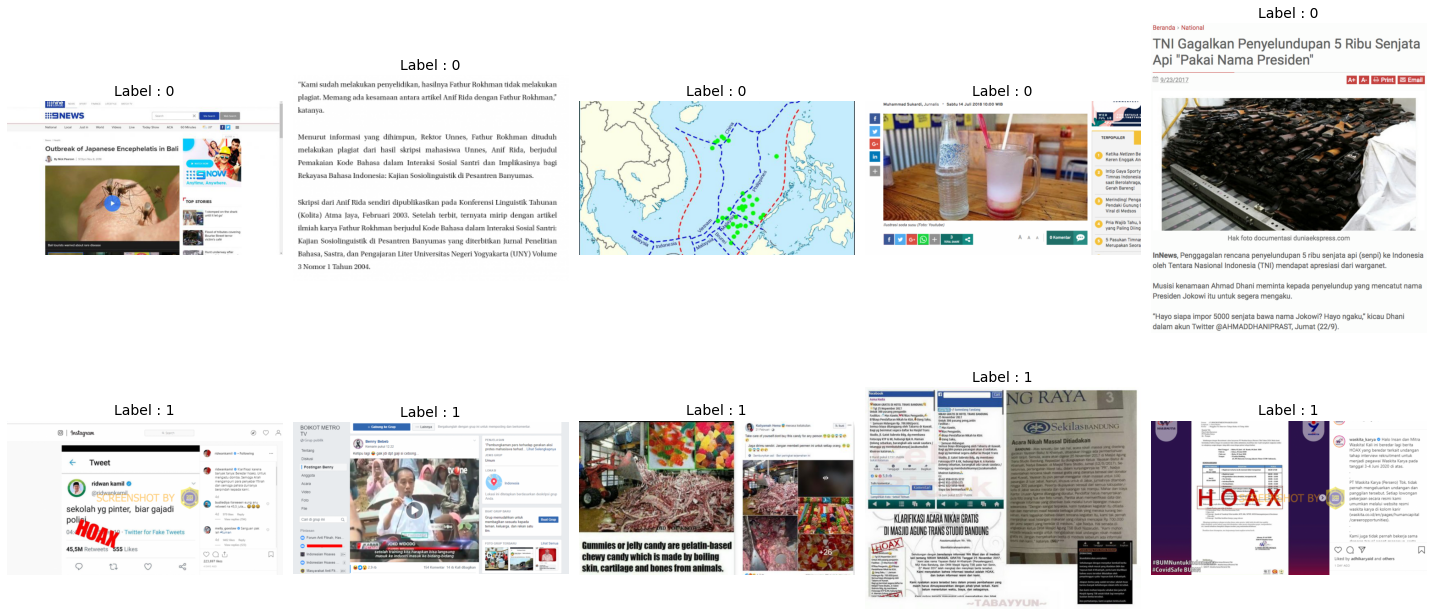

In [37]:
test_img_dir = ['../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/' + 
            x for x in test['nama file gambar'].values]
show_images(test_img_dir, best_predictions, seed = 100)

# Submission
Membuat Submission dataframe

In [38]:
sample = pd.read_csv('../input/data-bdc/Submission Template.csv')
sub = pd.DataFrame({'ID' : [int(x.split('/')[-1][:-4]) for x in test_img_dir],
                    'label' : best_predictions})
sub = sample.merge(sub, left_on = 'ID', right_on = 'ID')[['ID', 'label']]
sub.columns = ['ID', 'prediksi']
sub.head()

ID  prediksi
0     56         1
1   1129         1
2   8468         1
3   9527         1
4  11152         1

In [39]:
sub.to_csv('Submission.csv', index=False)

# Kesimpulan Sementara
Dari pengolahan data sampai dengan tahap ini di dapatkan kesimpulan:
1. Model masih kesulitan untuk membedakan kelas `0` dengan kelas `1`<br>
Dapat dilihat pada countplot prediction terdapat imbalance yang sangat jauh antara kelas `0` dengan kelas `1`, bahkan lebih tinggi dari data train. Hal ini cukup wajar karena tidak ada sesuatu yang spesifik dalam membedakan gambar kelas `0` dengan kelas `1`.
1. Model kemungkinan Overfit pada train data<br>
Hal ini ditandai dengan naiknya grafik / nilai `val_accuracy` & `val_F1` ketika nilai `val_loss` juga menaik.
1. Pemodelan dengan data gambar bukanlah pilihan yang baik<br>
Hal ini dapat disimpulkan dari performa dari model yang kurang baik dan saat melihat data gambar perkelasnya juga tidak terdapat sesuatu yang spesifik membedakan antara kelas `0` dan kelas `1`.

© Catatan Cakrawala 2020